In [4]:
#Imports and paths for detector dataset; load train annotations.
import json
import random
import shutil
from collections import Counter, defaultdict
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Paths (aligned to detector build output and classification dataset layout)
BASE_DATA_ROOT = Path("/Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO")

DETECTOR_ROOT = Path("/Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/detector")
TRAIN_JSON = DETECTOR_ROOT / "train" / "annotations" / "annotations.json"
TRAIN_IMG_DIR = DETECTOR_ROOT / "train" / "images"

AUG_ROOT = Path("/Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/augmented/detector")
AUG_IMG_DIR = AUG_ROOT / "train" / "images"
AUG_ANN_DIR = AUG_ROOT / "train" / "annotations"

AUG_IMG_DIR.mkdir(parents=True, exist_ok=True)
AUG_ANN_DIR.mkdir(parents=True, exist_ok=True)

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

with open(TRAIN_JSON, "r") as f:
    train_data = json.load(f)

print("Loaded train annotations:", len(train_data.get("images", [])))


Loaded train annotations: 2816


In [5]:
#Compute class imbalance on bounding boxes to decide augmentation multipliers per category.
class_counts = Counter([ann["category_id"] for ann in train_data.get("annotations", [])])
print("Class counts:", dict(class_counts))

max_count = max(class_counts.values()) if class_counts else 1
max_multiplier = 5  # cap to avoid runaway augmentation
aug_factor = {
    cid: max(1, min(max_multiplier, int(np.ceil(max_count / count)))) if count > 0 else 1
    for cid, count in class_counts.items()
}

print("Augmentation multiplier per class:", aug_factor)


Class counts: {2: 2560, 6: 225, 3: 651, 1: 1806, 5: 494, 4: 475}
Augmentation multiplier per class: {2: 1, 6: 5, 3: 4, 1: 2, 5: 5, 4: 5}


In [7]:
#Define bbox-safe augmentation pipeline (Albumentations or torchvision v2) with flips, color jitter, 
#small rotations, blur; include bbox format conversion helpers.
try:
   import albumentations as A
except ImportError:
    A = None


def xywh_to_xyxy(box):
    x, y, w, h = box
    return [x, y, x + w, y + h]

def xyxy_to_xywh(box):
    x1, y1, x2, y2 = box
    return [x1, y1, x2 - x1, y2 - y1]

def get_transform():
    if A is None:
        print("Albumentations not installed; using simple fallback augmentations.")
        return None

    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.7),
            A.MotionBlur(blur_limit=3, p=0.15),
            A.ShiftScaleRotate(
                shift_limit=0.01,
                scale_limit=0.05,
                rotate_limit=5,
                border_mode=0,
                p=0.3,
            ),
        ],
        bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"], min_visibility=0.1),
    )

transform = get_transform()

def apply_fallback_aug(pil_image, bboxes, labels):
    '''Simple fallback pipeline: optional hflip + mild brightness jitter.'''
    img = pil_image.copy()
    w, h = img.size

    # Horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        flipped = []
        for bbox in bboxes:
            x, y, bw, bh = bbox
            new_x = max(0.0, w - (x + bw))
            flipped.append([new_x, y, bw, bh])
        bboxes = flipped

    # Brightness jitter
    if random.random() < 0.5:
        factor = 0.9 + 0.2 * random.random()
        img = Image.fromarray(np.clip(np.array(img, dtype=np.float32) * factor, 0, 255).astype(np.uint8))

    return img, bboxes, labels

def augment_sample(pil_image, bboxes, labels):
    if transform is None:
        return apply_fallback_aug(pil_image, bboxes, labels)

    result = transform(
        image=np.array(pil_image),
        bboxes=bboxes,
        category_ids=labels,
    )
    aug_img = Image.fromarray(result["image"])
    return aug_img, result["bboxes"], result["category_ids"]


In [8]:
#Augment images per class multiplier, save augmented images, and create corresponding new annotation 
#entries with updated image IDs/file names and transformed bboxes.
anns_by_image = defaultdict(list)
for ann in train_data.get("annotations", []):
    anns_by_image[ann["image_id"]].append(ann)

next_image_id = max([img["id"] for img in train_data.get("images", [])], default=0) + 1
next_ann_id = max([ann["id"] for ann in train_data.get("annotations", [])], default=0) + 1

augmented_images = []
augmented_annotations = []

for img_info in train_data.get("images", []):
    image_id = img_info["id"]
    anns = anns_by_image.get(image_id, [])
    if not anns:
        continue

    # use the highest multiplier among categories present in this image
    multiplier = max([aug_factor.get(ann["category_id"], 1) for ann in anns])
    if multiplier <= 1:
        continue

    img_path = TRAIN_IMG_DIR / img_info["file_name"]
    if not img_path.exists():
        print(f"Missing image {img_info['file_name']}, skipping.")
        continue

    pil_img = Image.open(img_path).convert("RGB")
    base_boxes = [ann["bbox"] for ann in anns]
    base_labels = [ann["category_id"] for ann in anns]

    for i in range(multiplier):
        aug_img, aug_boxes, aug_labels = augment_sample(pil_img, base_boxes, base_labels)

        parts = img_info["file_name"].rsplit(".", 1)
        stem = parts[0]
        ext = f".{parts[1]}" if len(parts) > 1 else ""
        aug_filename = f"{stem}_aug{i+1}{ext}"

        aug_path = AUG_IMG_DIR / aug_filename
        aug_img.save(aug_path)

        width, height = aug_img.size
        new_img_id = next_image_id
        next_image_id += 1

        augmented_images.append({
            "id": new_img_id,
            "file_name": aug_filename,
            "width": width,
            "height": height,
        })

        for bbox, label in zip(aug_boxes, aug_labels):
            bbox = [float(v) for v in bbox]
            augmented_annotations.append({
                "id": next_ann_id,
                "image_id": new_img_id,
                "category_id": int(label),
                "bbox": bbox,
                "area": bbox[2] * bbox[3],
                "iscrowd": 0,
                "segmentation": [],
            })
            next_ann_id += 1

print(f"Created {len(augmented_images)} augmented images and {len(augmented_annotations)} annotations.")


Created 8249 augmented images and 19513 annotations.


In [9]:
# Merge originals + augmented annotations into a new COCO file (e.g., data/augmented/detector/train/annotations.json) 
# and copy originals + augmented images to the matching folder structure.
# Copy originals into augmented folder (if not already there)
for img in train_data.get("images", []):
    src = TRAIN_IMG_DIR / img["file_name"]
    dst = AUG_IMG_DIR / img["file_name"]
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)

all_images = train_data.get("images", []) + augmented_images
all_annotations = train_data.get("annotations", []) + augmented_annotations
categories = train_data.get("categories", [])

augmented_coco = {
    "images": all_images,
    "annotations": all_annotations,
    "categories": categories,
}

AUG_ANN_DIR.mkdir(parents=True, exist_ok=True)
aug_ann_path = AUG_ANN_DIR / "annotations.json"
with open(aug_ann_path, "w") as f:
    json.dump(augmented_coco, f, indent=2)

print(f"Saved augmented annotations to {aug_ann_path}")
print(f"Total images: {len(all_images)}, annotations: {len(all_annotations)}")


Saved augmented annotations to /Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/augmented/detector/train/annotations/annotations.json
Total images: 11065, annotations: 25724


Per-class annotation counts: {2: 7348, 6: 1350, 3: 3535, 1: 7677, 5: 2964, 4: 2850}


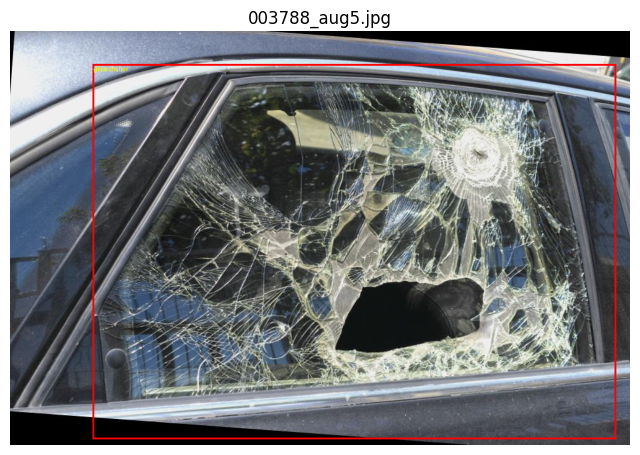

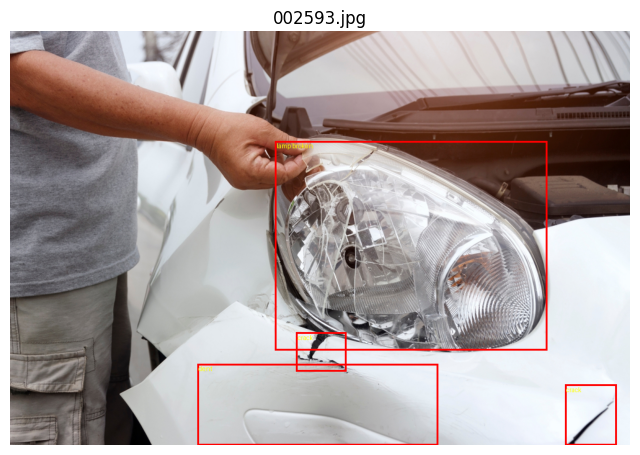

In [11]:
#Post-augmentation checks: per-class annotation counts, spot-check visualization of augmented boxes
def summarize_counts(coco):
    counts = Counter([ann["category_id"] for ann in coco.get("annotations", [])])
    print("Per-class annotation counts:", dict(counts))

def visualize_random(split_json_path, img_dir, num_images=2, max_boxes=5):
    from PIL import ImageDraw

    with open(split_json_path, "r") as f:
        coco = json.load(f)

    anns_by_image = defaultdict(list)
    for ann in coco.get("annotations", []):
        anns_by_image[ann["image_id"]].append(ann)

    id_to_image = {img["id"]: img for img in coco.get("images", [])}
    id_to_cat = {c["id"]: c["name"] for c in coco.get("categories", [])}

    chosen = random.sample(list(id_to_image.keys()), k=min(num_images, len(id_to_image)))
    for img_id in chosen:
        info = id_to_image[img_id]
        path = Path(img_dir) / info["file_name"]
        if not path.exists():
            print(f"Missing image {path}")
            continue

        img = Image.open(path).convert("RGB")
        draw = ImageDraw.Draw(img)
        for ann in anns_by_image.get(img_id, [])[:max_boxes]:
            x, y, w, h = ann["bbox"]
            cat = id_to_cat.get(ann["category_id"], "?")
            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
            draw.text((x + 2, y + 2), cat, fill="yellow")

        plt.figure(figsize=(8, 6))
        plt.title(f"{info['file_name']}")
        plt.imshow(img)
        plt.axis("off")
        plt.show()

summarize_counts(augmented_coco)

# Example (uncomment to run a quick visual check):
visualize_random(aug_ann_path, AUG_IMG_DIR, num_images=2)
